# Evaluating, Improving and Tuning the ANN

Tenemos un problema que al evaluar el mismo dataset con la red neuronal de nuevo o un dataset distinto, nuestra precisión (accuracy) no será la misma en todos los casos. Para lidiar con esto, utilizamos lo que se denomina como *"k-Fold Cross Validation"*. Soluciona este problema dividiendo nuestro set de entrenamiento, por ejemplo, en 10 partes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Part 1 - Data Preprocessing

In [45]:
# Import dataset
dataset = pd.read_csv("../datasets/churn/Churn_Modelling.csv")

In [46]:
# We'll not include the columns "RowNumber, CustomerId, Surname" (columns 0, 1, 2 starting with the number 0)
# Se incluirán los índices del 3 al 12
X = dataset.iloc[:, 3:13].values # No toma el último límite (13)
y = dataset.iloc[:, 13].values # Variable independiente (Clase binaria)

## Encoding Datos Categóricos

In [47]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [48]:
# Vamos a encodear los países para que se muestren cómo números (1,2,3...) en vez de sus nombres
labelencoder_X_1 = LabelEncoder()

In [49]:
# Tomamos la columna "Geography" con la posición "4" del dataset pero en la posición 1 de "X"
X[:,1] = labelencoder_X_1.fit_transform(X[:,1])

In [50]:
# Encodear columna de Género (posición 2 en array "X")
labelencoder_X_2 = LabelEncoder()

In [51]:
X[:,2] = labelencoder_X_2.fit_transform(X[:,2])

### Dummy Variables

Ya que no hay un orden categórico entre los paises (Alemania no está más alto que españa, o más bajo o cualquier otro ejemplo con ellos) es que deberemos crear Dummy variables 

In [52]:
onehotencoder = OneHotEncoder(categorical_features = [1]) #Columna 1 de Geography. [1] es el index

In [53]:
X = onehotencoder.fit_transform(X).toarray() # Hará onehotencoder sobre el index indicado arriba

C:\Anaconda3\envs\CursoDL\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\envs\CursoDL\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


### Dummy Variable Trap

* La solución a la **"Trampa de Variables Ficticias"** es descartar una de las variables categóricas (o, alternativamente, descartar la constante de intercepción): si hay m número de categorías, use m-1 en el modelo, el valor dejado de lado puede considerarse como "El valor de referencia" y los valores de ajuste de las categorías restantes representan el cambio de esta referencia.

* Sin embargo, al incluir la variable ficticia en un modelo de regresión, se debe tener cuidado con la trampa de la variable ficticia. La trampa de variables ficticias es un escenario en el que las variables independientes son multicolineales, un escenario en el que dos o más variables están altamente correlacionadas; En términos simples, una variable puede predecirse a partir de las otras.

* En nuestro caso eliminaremos la primera columna en la cual si había un "1" en ella significaba que el país de la fila era Francia. ¿Qué ocurre al eliminar esta columna? Todas las filas que correspondan a Francia se representarán con "0 - 0" en vez de hacerlo con "1 - 0 - 0" cuando realizabamos One Hot Encode ya que ahora tenemos una columna menos.

* Por lo tanto, para prevenir el *Dummy Variable Trap* eliminamos una columna y los paises quedarían representados de la siguiente manera:


    * France:  0 0
    * Germany: 1 0
    * Spain:   0 1

In [54]:
# Tomo todas las filas pero guardo desde la columna 1 hasta la última. No se toma en cuenta la columna 0
X = X[:, 1:] 

## Dividir el dataset en entrenamiento y prueba

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
# 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 

## Feature Scaling / Estandarización

In [57]:
from sklearn.preprocessing import StandardScaler

In [58]:
sc = StandardScaler()

In [59]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Evaluando la ANN con K-Fold Cross Validation

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [18]:
from keras.wrappers.scikit_learn import KerasClassifier

In [19]:
from sklearn.model_selection import cross_val_score

In [21]:
# Crea la arquitectura de nuestra red neuronal (cuando la creabamos con los clasifiers agregando las capas)

def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu')) 
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid')) 
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [22]:
# Este modelo (classifier) en vez de ser construido con los datos de entrenamiento (X_train, y_train) 
#... se hará con Cross Validation

# KerasClassifier es una clase por lo que creará un objeto en classifier
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100) 

In [23]:
# Aún no se aplica la cross validation por lo que usaremos sklearn con "cross_val_score"
# cv: determina la cross validation estrategia de separación. None: usa por defecto 3, o seleccionar un entero si no se quiere lo de defecto.
# n_jobs: el número de CPUs que utilizará para entrenar el modelo. Un -1 es que los utilizará todos.
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, n_jobs = -1)

In [36]:
from IPython.display import Image

## Bias - Variance
Siempre que analicemos la predicción del modelo, es importante comprender los errores de predicción (Bias (sesgo) y varianza). Existe una compensación entre la capacidad de un modelo para minimizar el Bias y la varianza. Obtener una comprensión adecuada de estos errores nos ayudaría no solo a construir modelos precisos, sino también a evitar el error de sobreajuste y falta de ajuste.

### Bias
El Bias es la diferencia entre la predicción promedio de nuestro modelo y el valor correcto que estamos tratando de predecir. El modelo con alto Bias presta muy poca atención a los datos de entrenamiento y simplifica demasiado el modelo. Siempre conduce a un alto error en los datos de entrenamiento y prueba.

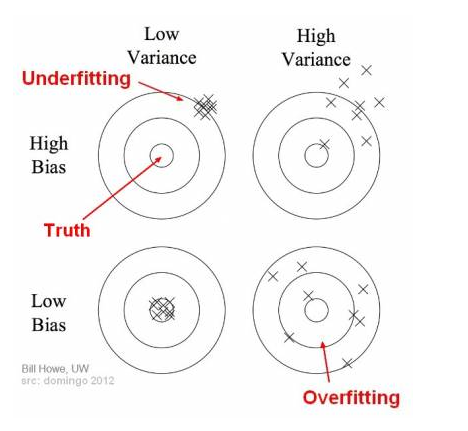

In [37]:
Image(filename = "resources/bias_bulleye.png")

En el diagrama anterior, el centro del objetivo es un modelo que predice perfectamente los valores correctos. A medida que nos alejamos de la diana, nuestras predicciones empeoran cada vez más. Podemos repetir nuestro proceso de construcción de modelos para obtener golpes separados en el objetivo.

En el aprendizaje supervisado, el "underfitting" (adaptación insuficiente) ocurre cuando un modelo no puede capturar el patrón subyacente de los datos. Estos modelos generalmente tienen un alto bias y una baja varianza. Ocurre cuando tenemos muy poca cantidad de datos para construir un modelo preciso o cuando intentamos construir un modelo lineal con datos no lineales. Además, este tipo de modelos son muy simples para capturar los patrones complejos en datos como la regresión lineal y logística.

En el aprendizaje supervisado, el sobreajuste ocurre cuando nuestro modelo captura el ruido junto con el patrón subyacente en los datos. Ocurre cuando entrenamos mucho nuestro modelo sobre un conjunto de datos ruidoso. Estos modelos tienen bajo bias y alta varianza. Estos modelos son muy complejos como los árboles de decisión que son propensos al sobreajuste.

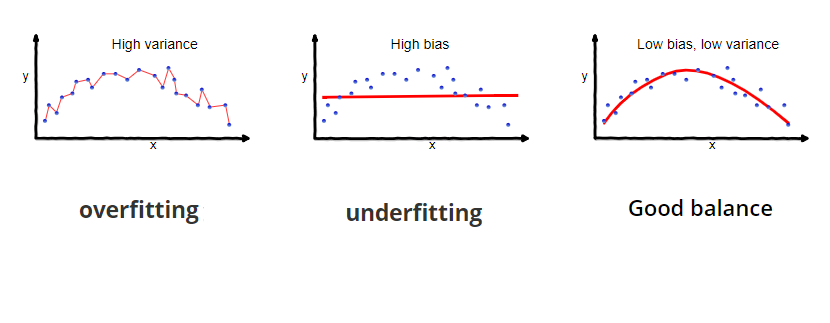

In [38]:
Image(filename = "resources/bias_graphic.png")

In [24]:
# Low Bias Low Variance
mean = accuracies.mean()
variance = accuracies.std()

In [39]:
print("Cross - Validation")
print("\nPromedio de la precisión de la ANN en el set de entrenamiento: {0:.2f}".format(mean*100), "%") # Alta precisión predicha
print("\nVarianza de la precisión de la ANN en el set de entrenamiento: {0:.2f}".format(variance*100), "%") # Baja Varianza

Cross - Validation

Promedio de la precisión de la ANN en el set de entrenamiento: 84.26 %

Varianza de la precisión de la ANN en el set de entrenamiento: 1.45 %


Tenemos una precisión del 83,31% en nuestra ANN anterior sin utilizar k-fold cross validation y un 84.26% con ella.